In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['F:/seg_train','F:/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|▎                                                                                | 7/2191 [00:00<00:33, 64.57it/s]

Loading F:/seg_train


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:09<00:00, 260.19it/s]


Loading F:/seg_test


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:02<00:00, 181.03it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


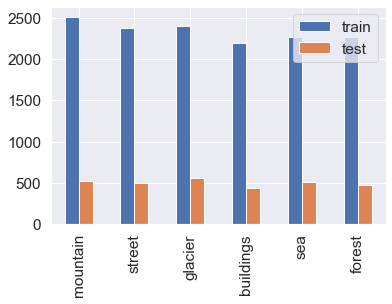

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

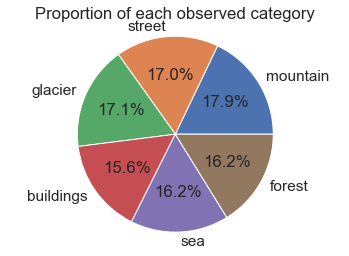

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

# Good practice: scale the data

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Visualize the data 

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

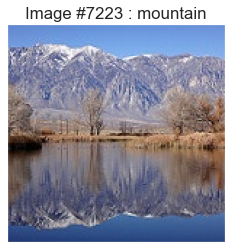

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

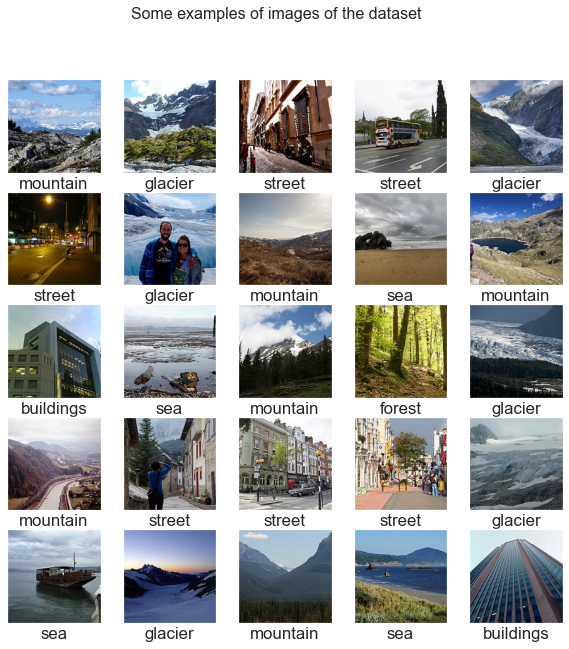

In [13]:
display_examples(class_names, train_images, train_labels)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [15]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=5, validation_split = 0.2)

Epoch 1/5
88/88 [==============================] - 151s 2s/step - loss: 1.1559 - accuracy: 0.5595 - val_loss: 0.9101 - val_accuracy: 0.6487
Epoch 2/5
88/88 [==============================] - 153s 2s/step - loss: 0.8149 - accuracy: 0.6964 - val_loss: 0.7929 - val_accuracy: 0.6911
Epoch 3/5
88/88 [==============================] - 166s 2s/step - loss: 0.6470 - accuracy: 0.7697 - val_loss: 0.6903 - val_accuracy: 0.7620
Epoch 4/5
88/88 [==============================] - 152s 2s/step - loss: 0.5347 - accuracy: 0.8110 - val_loss: 0.7028 - val_accuracy: 0.7460
Epoch 5/5
88/88 [==============================] - 153s 2s/step - loss: 0.4254 - accuracy: 0.8577 - val_loss: 0.7145 - val_accuracy: 0.7570


In [22]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

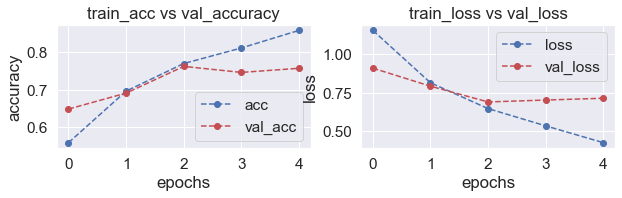

In [23]:
plot_accuracy_loss(history)